<h1>4. Machine Learning Models </h1>

In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

<h2> 4.1 Featurizing Data with TFIDF </h2>

In [2]:
final_df = pd.read_csv('advanced_features_train.csv')
final_df.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.99998,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759


In [3]:
final_df.dropna(axis=0, inplace=True)
Y = final_df['is_duplicate'].values
final_df.drop(['id', 'qid1', 'qid2', 'is_duplicate'], axis=1, inplace=True)
final_df.head(2)

,question1,question2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h2> 4.1.1 Random split --> train, cv, test (50:25:25)</h2>

In [4]:
Xtrain, X_, Ytrain, Y_ = train_test_split(final_df, Y, test_size=0.5)
Xcv, Xtest, Ycv, Ytest = train_test_split(X_, Y_, test_size=0.5)

In [5]:
print(f"Shape of Xtrain : {Xtrain.shape}")
print(f"Shape of Xcv    : {Xcv.shape}")
print(f"Shape of Xtest  : {Xtest.shape}")

Shape of Xtrain : (202143, 17)
Shape of Xcv    : (101072, 17)
Shape of Xtest  : (101072, 17)


In [6]:
Ytrain_dist = Counter(Ytrain)
Ytest_dist = Counter(Ytest)
Ycv_dist = Counter(Ycv)

print(f"Distribution of [class0(non_duplicates), class1(duplictes)]\n")
print(f"Ytrain ==> [class0 = {Ytrain_dist[0] / Ytrain.shape[0] : .3f}, class1 = {Ytrain_dist[1] / Ytrain.shape[0] : .3f}]")
print(f" Ytest ==> [class0 = {Ytest_dist[0] / Ytest.shape[0] : .3f}, class1 = {Ytest_dist[1] / Ytest.shape[0] : .3f}]")
print(f"  Ycv  ==> [class0 = {Ycv_dist[0] / Ycv.shape[0] : .3f}, class1 = {Ycv_dist[1] / Ycv.shape[0] : .3f}]")

Distribution of [class0(non_duplicates), class1(duplictes)]

Ytrain ==> [class0 =  0.631, class1 =  0.369]
 Ytest ==> [class0 =  0.631, class1 =  0.369]
  Ycv  ==> [class0 =  0.630, class1 =  0.370]


In [8]:
#sum up all the questions into one place and compute tfidf
questions = list(Xtrain['question1']) + list(Xtrain['question2'])


q_tfidf = TfidfVectorizer(min_df=0.00009,
                           max_features=200000,
                           ngram_range=(1, 4),
                           tokenizer= lambda text : text.split())

q_tfidf.fit(questions)
print(f"Number of unique words in col(question1) : {len(q_tfidf.get_feature_names())}")

Xtrain_q1_tfidf = q_tfidf.transform(Xtrain['question1'])
Xcv_q1_tfidf = q_tfidf.transform(Xcv['question1'])
Xtest_q1_tfidf = q_tfidf.transform(Xtest['question1'])

Xtrain_q2_tfidf = q_tfidf.transform(Xtrain['question2'])
Xcv_q2_tfidf = q_tfidf.transform(Xcv['question2'])
Xtest_q2_tfidf = q_tfidf.transform(Xtest['question2'])

Number of unique words in col(question1) : 28020


In [18]:
Xtrain_tfidf = hstack((Xtrain_q1_tfidf, Xtrain_q2_tfidf, Xtrain.values[:, 2:].astype(np.float64)))
Xcv_tfidf = hstack((Xcv_q1_tfidf, Xcv_q2_tfidf, Xcv.values[:, 2:].astype(np.float64)))
Xtest_tfidf = hstack((Xtest_q1_tfidf, Xtest_q2_tfidf, Xtest.values[:, 2:].astype(np.float64)))

In [19]:
print(f"Shape of Xtrain : {Xtrain_tfidf.get_shape()}")
print(f"Shape of Xcv    : {Xcv_tfidf.get_shape()}")
print(f"Shape of Xtest  : {Xtest_tfidf.get_shape()}")

Shape of Xtrain : (202143, 56055)
Shape of Xcv    : (101072, 56055)
Shape of Xtest  : (101072, 56055)


In [27]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    
    
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4), dpi=100)
    
    labels = [0, 1]
    # representing A in heatmap format
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap='summer_r', fmt=".3f",
                xticklabels=labels, yticklabels=labels, linewidths=0.5)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap='summer_r', fmt=".3f",
                xticklabels=labels, yticklabels=labels, linewidths=0.5)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap='summer_r', fmt=".3f",
                xticklabels=labels, yticklabels=labels, linewidths=0.8)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.1.3 Building a random model (Finding worst-case log-loss) </h2>

In [21]:
def random_model(Ytest):
    
    y_shape = Ytest.shape[0]
    pred_y = np.zeros((y_shape, 2))
    
    for i in range(y_shape):
        random_probs = np.random.rand(1, 2)
        pred_y[i] = random_probs / random_probs.sum()
        
    print(f"Log loss on Test Data using Random Model : {log_loss(Ytest, pred_y, eps=1e-15) : .3f}")
    pred_y = pred_y.argmax(1)
    plot_confusion_matrix(Ytest, pred_y)

Log loss on Test Data using Random Model :  0.886


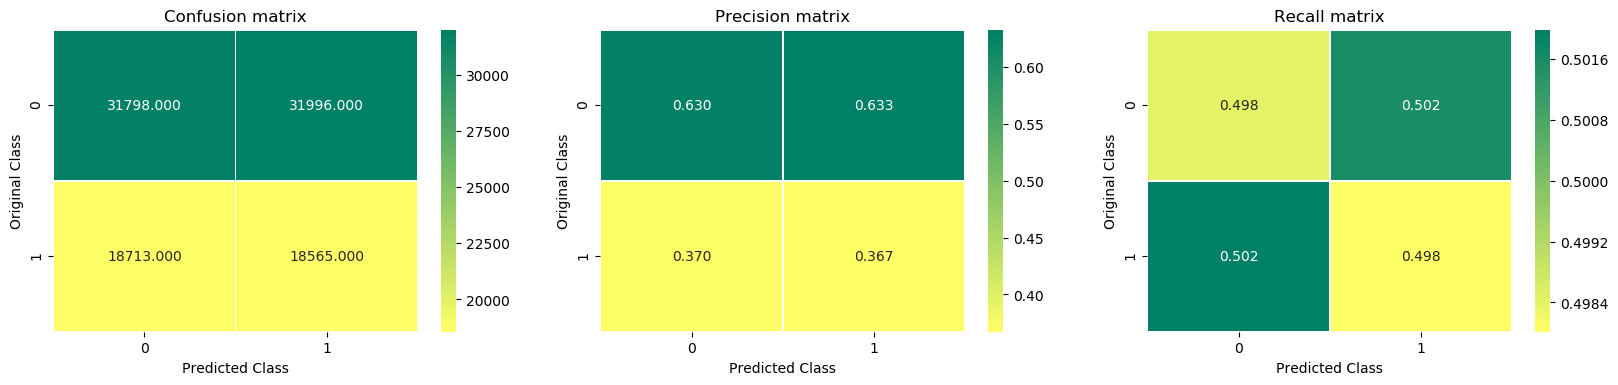

In [22]:
random_model(Ytest)

__The Rows of the Confusion Matrix sum up to #datapoints_from_each_class.__
<br>
__The Columns of the Precision Matrix add up to 1 while the rows of Recall Matrix add up to 1.__

* The random model has  *log_loss = 0.883*. 
* So the models built by us should have random_model's log_loss as the upper_bound(log_loss <= 0.883) to add any value.

<h2> 4.1.2 Linear Models </h2>

In [21]:
def find_optimal_c(Xtr, Ytr, Xcv, Ycv, loss=None, c_values=None):
    
    
    LOG_LOSSES = []
    c_values = np.round(c_values, 7)
    
    for c in c_values:
        clf = SGDClassifier(loss=loss, penalty='l2', alpha=c)
        clf.fit(Xtr, Ytr)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(Xtr, Ytr)
        sig_preds = sig_clf.predict_proba(Xcv)
        lgl = np.round(log_loss(Ycv, sig_preds), 3)
        LOG_LOSSES.append(lgl)
        print(f"c = {c}, log_loss = {lgl}")
        

    
    min_lgl = min(LOG_LOSSES)
    opt_c = c_values[np.argmin(LOG_LOSSES)]
    
    plt.figure(dpi=100)
    plt.plot(c_values, LOG_LOSSES, color='green', label='log_loss')
    plt.title(f"optimal c = {opt_c}")
    plt.annotate(f'({opt_c}, {min_lgl})', xy=(opt_c, min_lgl), textcoords='data')
    plt.xscale('log')
    plt.xlabel('C (1/lambda)')
    plt.ylabel('LOG_LOSSS')
    plt.legend()
    plt.grid()
    #plt.rcParams.update({'font.size':14})
    plt.tight_layout()

In [22]:
def evaluate_sgd_clf(Xtr, Ytr, Xte, Yte, loss=None, alpha=None):
    
    clf = SGDClassifier(loss=loss, penalty='l2', alpha=alpha).fit(Xtr, Ytr)
    sig_clf = CalibratedClassifierCV(clf).fit(Xtr, Ytr)
    
    probs_ytrain = sig_clf.predict_proba(Xtr)
    print(f"Train Log_loss : {log_loss(Ytr, probs_ytrain) : .3f}")

    probs_ytest = sig_clf.predict_proba(Xte)
    print(f"Test Log_loss : {log_loss(Yte, probs_ytest) : .3f}")
    Ypr = probs_ytest.argmax(1)
    
    plot_confusion_matrix(Yte, Ypr)
    

<h2> 4.1.3 Logistic Regression </h2>

* We'll build a Logistic Regression model on the train data.
* The optimal value of hyper parameter 'c'(l2_reg) can be found using CV.

c = 1e-07, log_loss = 0.659
c = 5e-07, log_loss = 0.566
c = 2.8e-06, log_loss = 0.549
c = 1.52e-05, log_loss = 0.562
c = 8.11e-05, log_loss = 0.552
c = 0.0004329, log_loss = 0.569
c = 0.0023101, log_loss = 0.546
c = 0.0123285, log_loss = 0.568
c = 0.0657933, log_loss = 0.576
c = 0.3511192, log_loss = 0.591
c = 1.8738174, log_loss = 0.596
c = 10.0, log_loss = 0.603


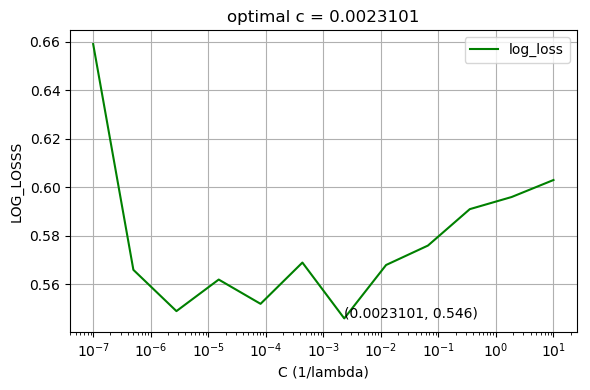

In [25]:
find_optimal_c(Xtrain_tfidf, Ytrain, Xcv_tfidf, Ycv, loss='log', c_values=np.logspace(-7, 1, 12))

Train Log_loss :  0.574
Test Log_loss :  0.575


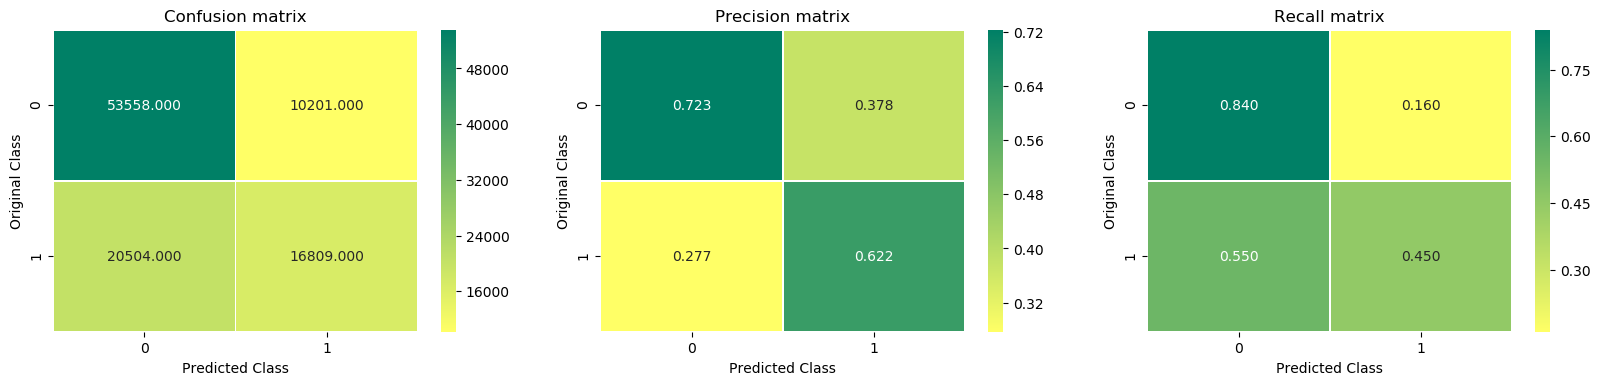

In [28]:
evaluate_sgd_clf(Xtrain_tfidf, Ytrain, Xtest_tfidf, Ytest, loss='log', alpha=0.0023101)

__Observations__

* Even though the log_loss <= 0.883, the performance of Logistic Regression looks meh.
* Even the precision seems okay, the recall for class 1 is very bad.
* It has very high FALSE NEGATIVES. We'll try to reduce it further by building a Linear SVM.

<h2> 4.1.4 Linear SVM </h2>

* We'll build a Linear SVM Model on the train data.
* The optimal value of hyper parameter 'c'(#soft margin) can be found using CV.

c = 1e-07, log_loss = 0.605
c = 5e-07, log_loss = 0.565
c = 2.8e-06, log_loss = 0.566
c = 1.52e-05, log_loss = 0.562
c = 8.11e-05, log_loss = 0.557
c = 0.0004329, log_loss = 0.575
c = 0.0023101, log_loss = 0.549
c = 0.0123285, log_loss = 0.57
c = 0.0657933, log_loss = 0.584
c = 0.3511192, log_loss = 0.591
c = 1.8738174, log_loss = 0.602
c = 10.0, log_loss = 0.638


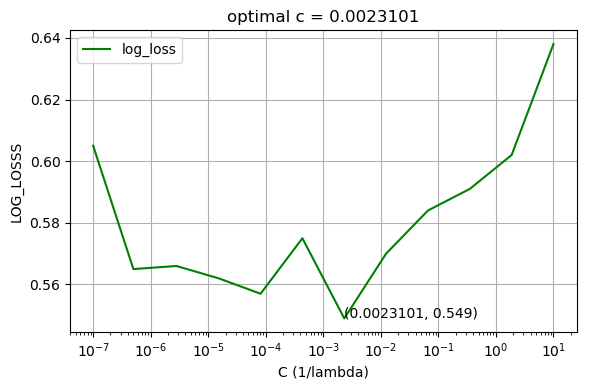

In [29]:
find_optimal_c(Xtrain_tfidf, Ytrain, Xcv_tfidf, Ycv, loss='hinge', c_values=np.logspace(-7, 1, 12))

Train Log_loss :  0.547
Test Log_loss :  0.548


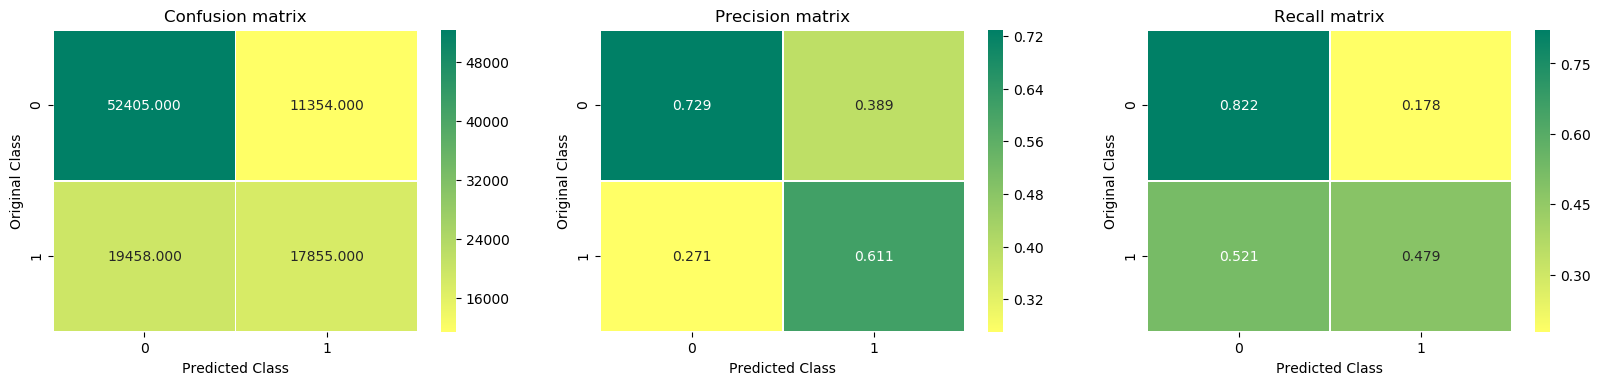

In [30]:
evaluate_sgd_clf(Xtrain_tfidf, Ytrain, Xtest_tfidf, Ytest, loss='hinge', alpha=0.0023101)

__Observations__

* The performance of Linear SVM is slighly higher to that of Logistic Regression.
* But it has still bad recall scores.

<h2> 4.2 Featrizing data with TFIDF and GLOVE </h3>

In [2]:
final_df = pd.read_csv('final_features.csv')
print(f"Shape of final_df : {final_df.shape[0]} rows, {final_df.shape[1]} columns")

Shape of final_df : 404290 rows, 628 columns


In [3]:
final_df.dropna(axis=0, inplace=True)
Y = final_df['is_duplicate'].values
final_df.drop(['id', 'is_duplicate'], axis=1, inplace=True)
final_df.head(1)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0.99998,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,...,0.042149,-0.266782,-0.027568,0.010603,0.158274,0.50526,-0.227644,-0.245269,0.031774,-0.143702


<h2> 4.2.1 Random split --> train, cv, test (50:25:25) </h2>

In [4]:
Xtrain, X_, Ytrain, Y_ = train_test_split(final_df, Y, test_size=0.5)
Xcv, Xtest, Ycv, Ytest = train_test_split(X_, Y_, test_size=0.5)

In [5]:
print(f"Shape of Xtrain : {Xtrain.shape}")
print(f"Shape of Xcv    : {Xcv.shape}")
print(f"Shape of Xtest  : {Xtest.shape}")

Shape of Xtrain : (202143, 626)
Shape of Xcv    : (101072, 626)
Shape of Xtest  : (101072, 626)


In [6]:
Ytrain_dist = Counter(Ytrain)
Ytest_dist = Counter(Ytest)
Ycv_dist = Counter(Ycv)

print(f"Distribution of [class0(non_duplicates), class1(duplictes)]\n")
print(f"Ytrain ==> [class0 = {Ytrain_dist[0] / Ytrain.shape[0] : .3f}, class1 = {Ytrain_dist[1] / Ytrain.shape[0] : .3f}]")
print(f" Ytest ==> [class0 = {Ytest_dist[0] / Ytest.shape[0] : .3f}, class1 = {Ytest_dist[1] / Ytest.shape[0] : .3f}]")
print(f"  Ycv  ==> [class0 = {Ycv_dist[0] / Ycv.shape[0] : .3f}, class1 = {Ycv_dist[1] / Ycv.shape[0] : .3f}]")

Distribution of [class0(non_duplicates), class1(duplictes)]

Ytrain ==> [class0 =  0.630, class1 =  0.370]
 Ytest ==> [class0 =  0.631, class1 =  0.369]
  Ycv  ==> [class0 =  0.631, class1 =  0.369]


<h2> 4.3 Linear Models </h2>

<h2> 4.3.1 Logistic Regression </h2>

* We'll build a Logistic Regression model on the train data.
* The optimal value of hyper parameter 'c'(l2_reg) can be found using CV.

c = 1e-06, log_loss = 0.441
c = 6e-06, log_loss = 0.428
c = 3.59e-05, log_loss = 0.429
c = 0.0002154, log_loss = 0.423
c = 0.0012915, log_loss = 0.423
c = 0.0077426, log_loss = 0.426
c = 0.0464159, log_loss = 0.429
c = 0.2782559, log_loss = 0.46
c = 1.6681005, log_loss = 0.49
c = 10.0, log_loss = 0.539


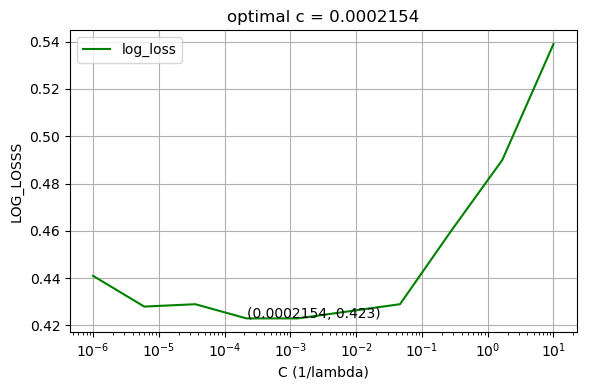

In [28]:
find_optimal_c(Xtrain, Ytrain, Xcv, Ycv, loss='log', c_values=np.logspace(-6, 1, 10))

Train Log_loss :  0.419
Test Log_loss :  0.419


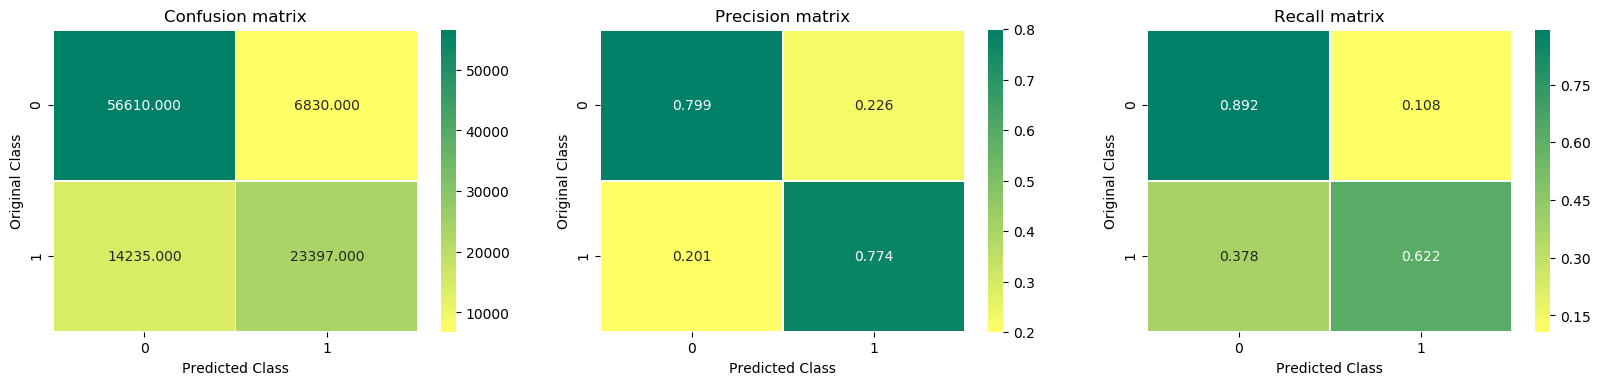

In [102]:
evaluate_sgd_clf(Xtrain, Ytrain, Xtest, Ytest, loss='log', alpha=0.0002154)

__Observations__

* The __Logistic Regression model__ has performed decently. It has mid TPR and high TNR.
* The precision and recall values also look good.
* The recall of class1(duplicate pairs) is less due to imbalance in the data.
* As mentioned, the cost of misclassification is very high, we'll try to reduce it further by building a __Linear SVM__.

<h2> 4.3.2 Linear SVM </h2>

* We'll build a Linear SVM Model on the train data.
* The optimal value of hyper parameter 'c'(#soft margin) can be found using CV.

c = 1e-06, log_loss = 0.428
c = 6e-06, log_loss = 0.433
c = 3.59e-05, log_loss = 0.441
c = 0.0002154, log_loss = 0.422
c = 0.0012915, log_loss = 0.426
c = 0.0077426, log_loss = 0.429
c = 0.0464159, log_loss = 0.433
c = 0.2782559, log_loss = 0.447
c = 1.6681005, log_loss = 0.479
c = 10.0, log_loss = 0.528


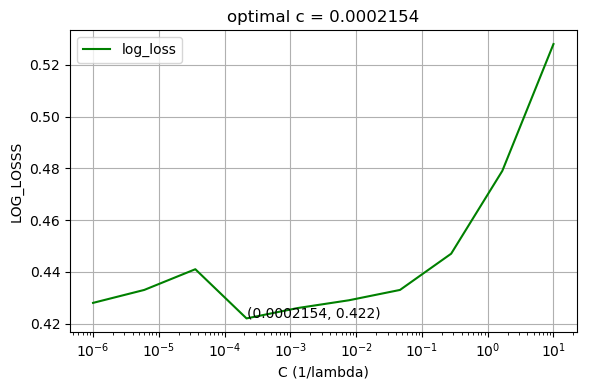

In [73]:
find_optimal_c(Xtrain, Ytrain, Xcv, Ycv, loss='hinge', c_values=np.logspace(-6, 1, 10))

Train Log_loss :  0.421
Test Log_loss :  0.421


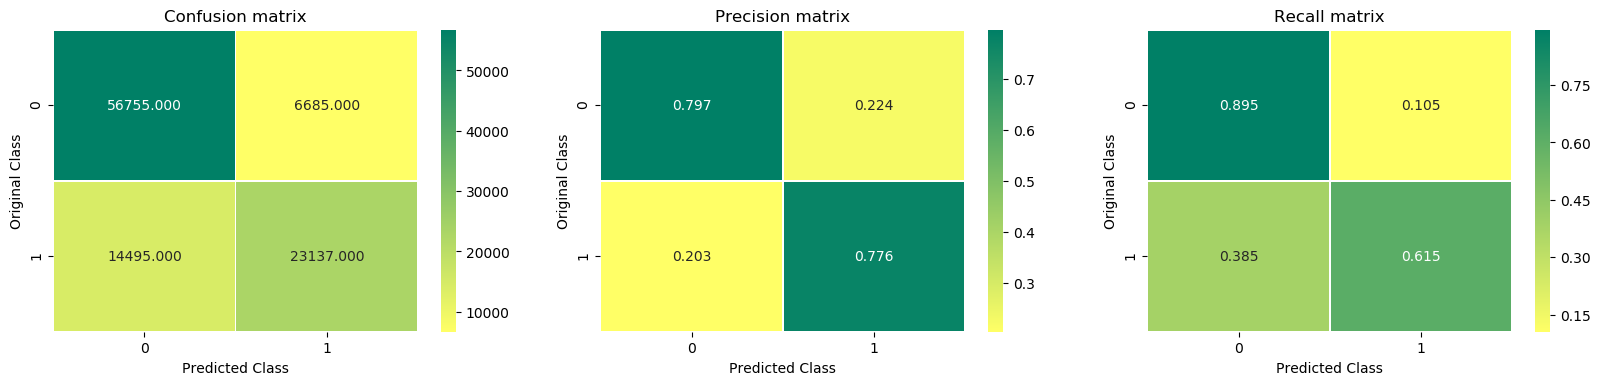

In [103]:
evaluate_sgd_clf(Xtrain, Ytrain, Xtest, Ytest, loss='log', alpha=0.0002154)

__Observations__

* Performance of Linear SVM is same as that of Logistic Regression.
* The recall is slightly on the lower side.
* We'll try to reduce it further by building __XGBoost__ Model.

<h2>4.4 Non-Linear Models : XGBoost </h2>

* Boosting is chain of models in which a model is the function over the error of the previous model.
* Typically weak learners(high bias models) like decision stumps are used as models.
* Unlike Linear Models, Boosting Models can learn non-linear decision boundaries.

In [ ]:
from xgboost import XGBClassifier

In [37]:
def tune_hyp_param(Xtrain, Ytrain, Xcv, Ycv, max_depth_vals=None, n_tree_vals=None):
    
    LOG_LOSSES = np.zeros((len(max_depth_vals), len(n_tree_vals)))
    
    for i, depth in enumerate(max_depth_vals):
        print(f"depth = {depth}")
        for j, n_trees in enumerate(n_tree_vals):
            clf = XGBClassifier(max_depth=depth, n_estimators=n_trees, n_jobs=6)
            clf.fit(Xtrain, Ytrain)
            cv_probs = clf.predict_proba(Xcv)
            lgl = np.round(log_loss(Ycv, cv_probs), 3)
            LOG_LOSSES[i, j] = lgl
            print(f"            n_trees = {n_trees}, log_loss = {lgl}")
            
    return LOG_LOSSES
            

In [47]:
log_losses = tune_hyp_param(Xtrain, Ytrain, Xcv, Ycv, max_depth_vals=[4, 8, 10, 15], n_tree_vals=[20, 30, 40, 50, 80])

depth = 4
            n_trees = 20, log_loss = 0.41
            n_trees = 30, log_loss = 0.387
            n_trees = 40, log_loss = 0.375
            n_trees = 50, log_loss = 0.368
            n_trees = 80, log_loss = 0.353
depth = 8
            n_trees = 20, log_loss = 0.377
            n_trees = 30, log_loss = 0.353
            n_trees = 40, log_loss = 0.342
            n_trees = 50, log_loss = 0.335
            n_trees = 80, log_loss = 0.324
depth = 10
            n_trees = 20, log_loss = 0.369
            n_trees = 30, log_loss = 0.344
            n_trees = 40, log_loss = 0.333
            n_trees = 50, log_loss = 0.327
            n_trees = 80, log_loss = 0.317
depth = 15
            n_trees = 20, log_loss = 0.361
            n_trees = 30, log_loss = 0.336
            n_trees = 40, log_loss = 0.327
            n_trees = 50, log_loss = 0.323
            n_trees = 80, log_loss = 0.322


Text(33.0, 0.5, 'max_depth')

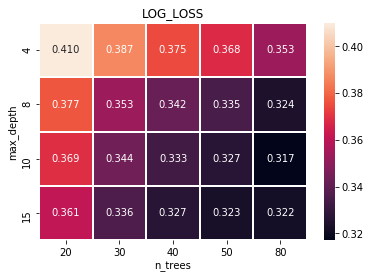

In [52]:
max_depth_vals = [4, 8, 10, 15]
n_tree_vals = [20, 30, 40, 50, 80]
sns.heatmap(log_losses, annot=True, fmt='.3f', xticklabels=n_tree_vals, yticklabels=max_depth_vals, linewidths=0.8)
plt.title("LOG_LOSS")
plt.xlabel('n_trees')
plt.ylabel('max_depth')

* At __max_depth = 10 and n_estimators = 80__, the log_loss is minimum

Test Loss : 0.317690337032313


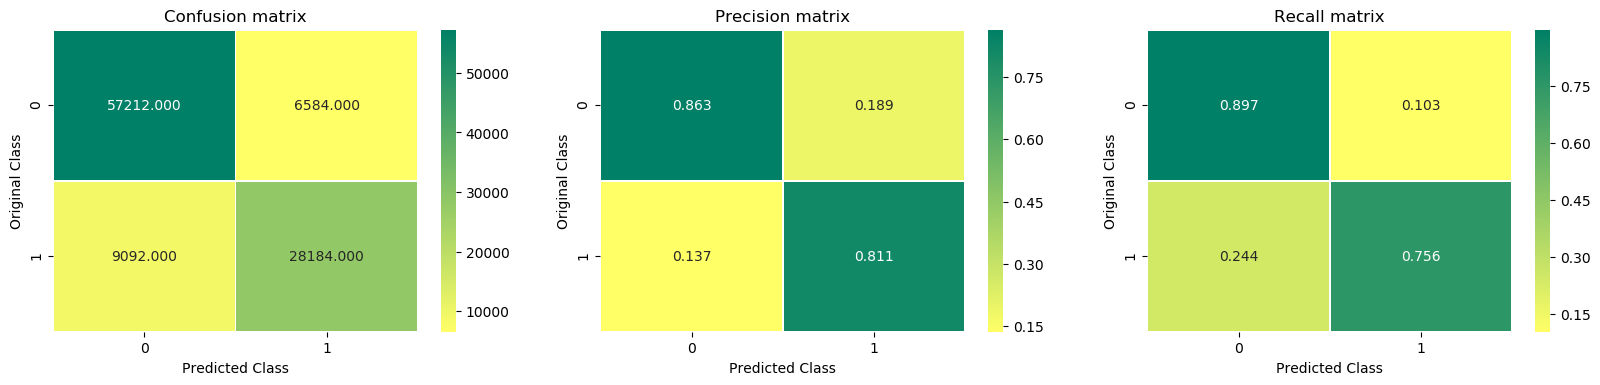

In [60]:
xgb_clf = XGBClassifier(max_depth=10, n_estimators=80, n_jobs=-1)
xgb_clf.fit(Xtrain, Ytrain)

xgb_probs = xgb_clf.predict_proba(Xtest)
print(f"Test Loss : {log_loss(Ytest, xgb_probs)}")

xgb_preds = xgb_probs.argmax(1)
plot_confusion_matrix(Ytest, xgb_preds)

* The XGB Model has very high precision and high recall than Linear Models.
* The performance over the imbalance class has significantly improved.

<h1> 5. Conclusion </h1>

<pre>
* We've used two featurizations for building the models.
   - TfIdf Word Vectors
   - TfIdf Weighted GloVe

* We've used three types of models.
   - Logistic Regression
   - Linear SVM
   - XGBoost
 
* The Linear Models built on both the featurizations were unable to perform well.
* They had low recall values for the class1(duplicate pairs).

* The Non-Linear Model XGBoost performwd significantly well compared to Linear Models.
* It had reasonable precision and recall values for both the classes.
</pre>

In [ ]:
+---------------------------------+------------+------------+----------+
|       MODEL                     |  LOG_LOSS  | PRECISION  |  RECALL  | 
+---------------------------------+------------+------------+----------+
|    Random Model                 |   0.866    |   0.499    |   0.498  |
|    Log_Regression (TFIDF)       |   0.575    |   0.672    |   0.645  |
|    Linear SVM (TFIDF)           |   0.548    |   0.670    |   0.650  |
|    Log_Regression (TFIDF-GLOVE) |   0.419    |   0.787    |   0.757  |
|    Linear SVM (TFIDF-GLOVE)     |   0.421    |   0.787    |   0.755  |
|    XGBoost (TFIDF-GLOVE)        |   0.317    |   0.83     |   0.827  |
+---------------------------------+------------+------------+---------+